# MVAE Perfomance Test

Load the action-recognition project from github and make import

In [1]:
import os
import sys

!git clone https://github.com/grushety/action_recognition.git 

Cloning into 'action_recognition'...
remote: Enumerating objects: 244, done.
remote: Counting objects: 100% (244/244), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 244 (delta 152), reused 198 (delta 106), pack-reused 0
Receiving objects: 100% (244/244), 6.49 MiB | 15.46 MiB/s, done.
Resolving deltas: 100% (152/152), done.


In [16]:
import numpy as np
!pip install tensorflow==1.3.0
import tensorflow as tf
import scipy.io
import math
import pandas as pd

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"] = (10,5)

### Change current model names

In [13]:
PATH = "/content/action_recognition/scripts/learning"

# Networks trained with Zambelli's dataset
z_rec = "./models/z_rec_network.ckpt"
z_pred = "./models/z_pred_network.ckpt"
z_mix = "./models/z_mixed_network.ckpt"

# Networks trained with Pepper dataset
pred= "./models/pred_network.ckpt"
rec= "./models/rec_network.ckpt"
mix =  "./models/mix_network.ckpt"

first_model = mix
second_model = z_mix

## Test MVAE on Pepper dataset

#### Load test set

In [7]:
data = scipy.io.loadmat(PATH + "/database/test_data.mat")
X_test = data["data"]
print(X_test.shape)

(300, 10)


### Configure test params

In [24]:
# mode describes what part of input vector should be missing
recon_modes = ["full", "first_half", "second_half", "mismode"]
pred_modes = ["both", "one"]
# or witch part of output vector will be evaluated
out_modes = ["first", "second"]

# please choose the mode
r_mode = recon_modes[1]
p_mode = pred_modes[0]
o_mode = out_modes[1]

denoise = True

### Open the model and run tests

In [10]:
%cd /content/action_recognition/scripts/learning
from mvae import VariationalAutoencoder
from mvae import network_param

/content/action_recognition/scripts/learning
(55000, 20)


In [25]:
with tf.Graph().as_default() as g:
    with tf.Session() as sess:
        # Network parameters
        network_architecture = network_param()
        learning_rate = 0.00001
        batch_size = 1

        model = VariationalAutoencoder(sess, network_architecture, batch_size=batch_size, learning_rate=learning_rate,
                                       vae_mode=False, vae_mode_modalities=False)
    with tf.Session() as sess:
        new_saver = tf.train.Saver()
        new_saver.restore(sess, first_model)
        print("Model restored.")
        real_x, real_y, recon_x, recon_y, pred_x, pred_y = [], [], [], [], [], []
        real_SP, real_SR, real_ER, recon_SP, recon_SR, recon_ER, pred_SP, pred_SR, pred_ER = [], [], [], [], [], [], [], [], []
        for i in range(len(X_test)):
            original_vector = list(X_test[i])
            original_vector = original_vector[:6] + [i/1000 for i in original_vector[6:]]         

            if r_mode == "full":
              input_rec1 = input_rec2 = original_vector

            if r_mode == "mismode":
            # Missing full mode
              input_rec1 = original_vector[:6] + [-2, -2, -2, -2]      
              input_rec2 = [-2, -2, -2, -2, -2, -2] + original_vector[6:] 

            if r_mode == "first_half":
            # Missing first half mode
              input_rec1 = original_vector[:6] + [-2, -2]  + original_vector[8:]    
              input_rec2 = [-2, -2, -2] + original_vector[3:]

            if r_mode == "second_half":
            # Missing second half mode
              input_rec1 = original_vector[:8] + [-2, -2]     
              input_rec2 = original_vector[:3] + [-2, -2, -2] + original_vector[6:]

            x_reconstruct, x = model.reconstruct(sess,  [input_rec1])
            x_reconstruct2, x = model.reconstruct(sess,  [input_rec2])

            if p_mode == "both":
            # Predict both modality at once 
              input_pred = input_pred2 = original_vector[:3] + [-2, -2, -2] + original_vector[6:8] + [-2, -2]

            if p_mode == "one":
            # Predict just one modality
              input_pred = original_vector[:3] + [-2, -2, -2] + original_vector[6:]
              input_pred2 = original_vector[:8] + [-2, -2]

            x_pred, x = model.reconstruct(sess,  [input_pred])
            x_pred2, x = model.reconstruct(sess,  [input_pred2])

            if denoise:
              x_pred, x = model.reconstruct(sess,  x_pred)
              x_pred2, x = model.reconstruct(sess,  x_pred2)
            
            if o_mode == "first":
              fact_joints = original_vector[:3]
              fact_points = original_vector[6:8]
              reconstr_joints = x_reconstruct2[0][:3]
              reconstr_points = x_reconstruct[0][6:8]
              pred_joints = x_pred[0][:3]
              pred_points = x_pred2[0][6:8]
            else:
              fact_joints = original_vector[3:6]
              fact_points = original_vector[8:]
              reconstr_joints = x_reconstruct2[0][3:6]
              reconstr_points = x_reconstruct[0][8:]
              pred_joints = x_pred[0][3:6]
              pred_points = x_pred2[0][8:]
            
            real_x.append(fact_points[0])
            real_y.append(fact_points[1])
            recon_x.append(reconstr_points[0])
            recon_y.append(reconstr_points[1])
            pred_x.append(pred_points[0])
            pred_y.append(pred_points[1])
            real_SP.append(fact_joints[0])
            real_SR.append(fact_joints[1])
            real_ER.append(fact_joints[2])
            recon_SP.append(reconstr_joints[0])
            recon_SR.append(reconstr_joints[1])
            recon_ER.append(reconstr_joints[2])
            pred_SP.append(pred_joints[0])
            pred_SR.append(pred_joints[1])
            pred_ER.append(pred_joints[2])
      

INFO:tensorflow:Restoring parameters from ./models/mix_network.ckpt
Model restored.


### Statistics

In [26]:

x_o, x_p, x_r, y_o, y_p, y_r = np.array((real_x)), np.array((pred_x)), np.array((recon_x)), np.array((real_y)), np.array((pred_y)), np.array((recon_y))
sp_o, sp_p, sp_r = np.array((real_SP)), np.array((pred_SP)), np.array((recon_SP))
sr_o, sr_p, sr_r = np.array((real_SR)), np.array((pred_SR)), np.array((recon_SR))
er_o, er_p, er_r = np.array((real_ER)), np.array((pred_ER)), np.array((recon_ER))
names = ["x","y", "SP", "SR", "ER"]
rec_mae = [mae(x_o, x_r), mae(y_o, y_r), mae(sp_o, sp_r), mae(sr_o, sr_r), mae(y_o, y_r)]
rec_mae = [np.round(i,5) for i in rec_mae]
rec_mse = [mse(x_o, x_r), mse(y_o, y_r), mse(sp_o, sp_r), mse(sr_o, sr_r), mse(y_o, y_r)]
rec_mse = [np.round(i,5) for i in rec_mse]
rec_r2 = [r2(x_o, x_r), r2(y_o, y_r), r2(sp_o, sp_r), r2(sr_o, sr_r), r2(y_o, y_r)]
rec_r2 = [np.round(i,5) for i in rec_r2]

out_r = {'names': names,
        'mae': rec_mae,
        'mse': rec_mse,
        'r2': rec_r2
        }

recs = pd.DataFrame (out_r, columns = ['names','mae', 'mse', 'r2'])
print("Reconstruction statistics")
print(recs)

pred_mae = [mae(x_o, x_p), mae(y_o, y_p), mae(sp_o, sp_p), mae(sr_o, sr_p), mae(y_o, y_p)]
pred_mae = [np.round(i,5) for i in rec_mae]
pred_mse = [mse(x_o, x_p), mse(y_o, y_p), mse(sp_o, sp_p), mse(sr_o, sr_p), mse(y_o, y_p)]
pred_mse = [np.round(i,5) for i in rec_mse]
pred_r2 = [r2(x_o, x_p), r2(y_o, y_p), r2(sp_o, sp_p), r2(sr_o, sr_p), r2(y_o, y_p)]
pred_r2 = [np.round(i,5) for i in rec_r2]

out_p = {'names': names,
        'mae': pred_mae,
        'mse': pred_mse,
        'r2': pred_r2
        }

preds = pd.DataFrame (out_p, columns = ['names','mae', 'mse', 'r2'])
print(" ")
print("Prediction statistics")
print(preds)

Reconstruction statistics
  names      mae      mse       r2
0     x  0.00745  0.00012  0.98958
1     y  0.02046  0.00076  0.95339
2    SP  0.00350  0.00004  0.99933
3    SR  0.00471  0.00006  0.99773
4    ER  0.02046  0.00076  0.95339
 
Prediction statistics
  names      mae      mse       r2
0     x  0.00745  0.00012  0.98958
1     y  0.02046  0.00076  0.95339
2    SP  0.00350  0.00004  0.99933
3    SR  0.00471  0.00006  0.99773
4    ER  0.02046  0.00076  0.95339


### Plot results

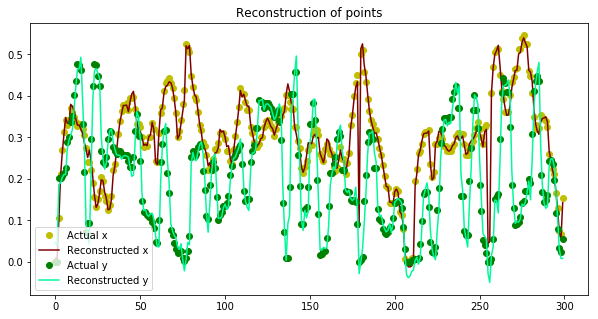

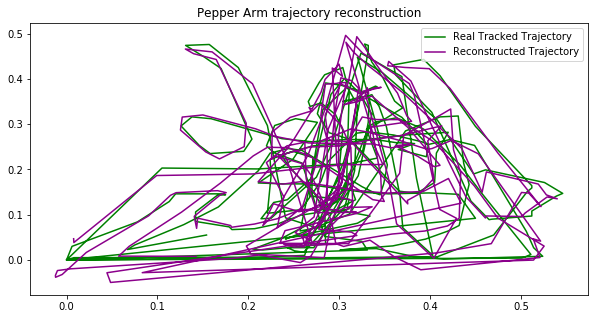

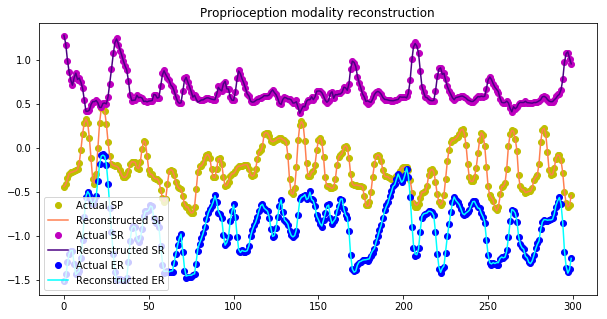

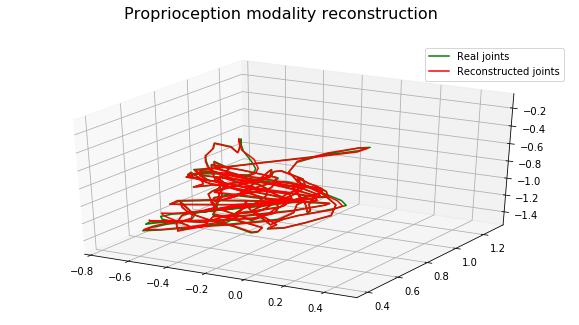

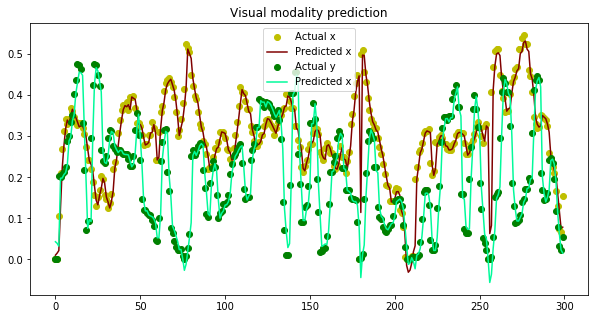

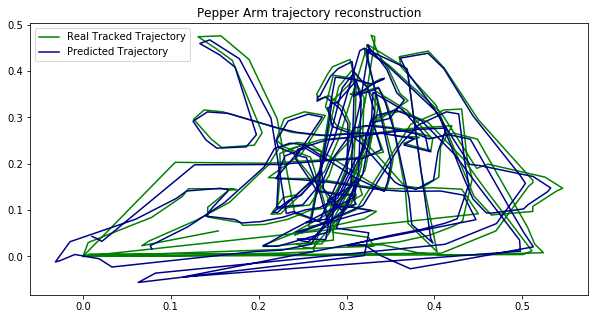

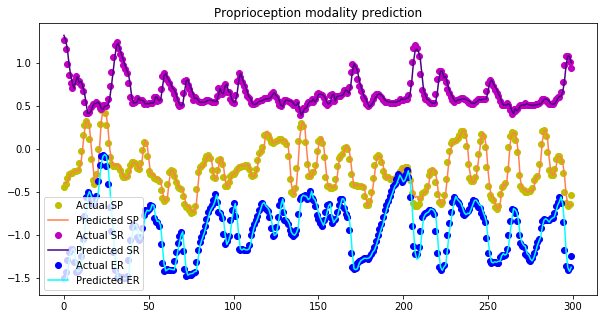

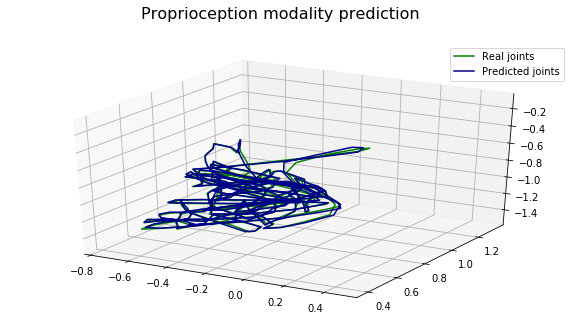

In [27]:
#reconstructed

plt.plot(real_x, 'yo', label="Actual x")
plt.plot(recon_x, label="Reconstructed x", color='maroon')
plt.plot(real_y, 'go',label="Actual y")
plt.plot(recon_y, label="Reconstructed y", color='mediumspringgreen')
plt.title('Reconstruction of points')
plt.legend()
plt.show()

plt.plot(real_x, real_y, label='Real Tracked Trajectory', color='green')
plt.plot(recon_x, recon_y, label='Reconstructed Trajectory', color='darkmagenta')
plt.title("Pepper Arm trajectory reconstruction")
plt.legend()
plt.show() 

plt.plot(real_SP, 'yo', label="Actual SP")
plt.plot(recon_SP, color='coral', label="Reconstructed SP")
plt.plot(real_SR, 'mo', label="Actual SR")
plt.plot(recon_SR, color='indigo', label="Reconstructed SR")
plt.plot(real_ER, 'bo', label="Actual ER")
plt.plot(recon_ER, color='cyan', label="Reconstructed ER")
plt.title('Proprioception modality reconstruction')
plt.legend()
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
fig.suptitle('Proprioception modality reconstruction', fontsize=16)
ax.plot(real_SP,real_SR, real_ER, label='Real joints', color='green')
ax.plot(recon_SP,recon_SR, recon_ER, label='Reconstructed joints', color='red')
#ax.title("Pepper Arm Joint configuration")
ax.legend()
plt.show()


#predicted

plt.plot(real_x, 'yo', label="Actual x")
plt.plot(pred_x, color='maroon', label="Predicted x")
plt.plot(real_y, 'go',label="Actual y")
plt.plot(pred_y, color='mediumspringgreen', label="Predicted x")
plt.title('Visual modality prediction')
plt.legend()
plt.show()

plt.plot(real_x, real_y, label='Real Tracked Trajectory', color='green')
plt.plot(pred_x, pred_y, label='Predicted Trajectory', color='darkblue')
plt.title("Pepper Arm trajectory reconstruction")
plt.legend()
plt.show()

plt.plot(real_SP, 'yo', label="Actual SP")
plt.plot(pred_SP, color='coral', label="Predicted SP")
plt.plot(real_SR, 'mo', label="Actual SR")
plt.plot(pred_SR, color='indigo', label="Predicted SR")
plt.plot(real_ER, 'bo', label="Actual ER")
plt.plot(pred_ER, color='cyan', label="Predicted ER")
plt.title('Proprioception modality prediction')
plt.legend()
plt.show()


fig = plt.figure()
ax = fig.gca(projection='3d')
fig.suptitle('Proprioception modality prediction', fontsize=16)
ax.plot(real_SP,real_SR, real_ER, label='Real joints', color='green')
ax.plot(pred_SP,pred_SR, pred_ER, label='Predicted joints', color='darkblue')
ax.legend()
plt.show()

## Test MVAE on Zambelli dataset

#### Load test set

In [29]:
data = scipy.io.loadmat(PATH + "/database/z_test.mat")
Z_test = data["data"]
Z_test = Z_test[:300]
print(Z_test.shape)

(300, 16)


### Configure test params

In [34]:
# mode describes what part of input vector should be missing
recon_modes = ["full", "first_half", "second_half", "mismode"]
pred_modes = ["both", "one"]
# or witch part of output vector will be evaluated
out_modes = ["first", "second"]

# please choose the mode
r_mode = recon_modes[1]
p_mode = pred_modes[1]
o_mode = out_modes[1]

denoise = True

### Open the model and run tests

In [30]:
from mvae_extended import VariationalAutoencoder as VariationalAutoencoderZ
from mvae_extended import network_param as network_paramZ

(29520, 32)


In [37]:
with tf.Graph().as_default() as g:
    with tf.Session() as sess:
        # Network parameters
        network_architecture = network_paramZ()
        learning_rate = 0.00001
        batch_size = 1

        model = VariationalAutoencoderZ(sess, network_architecture, batch_size=batch_size, learning_rate=learning_rate,
                                       vae_mode=False, vae_mode_modalities=False)
    with tf.Session() as sess:
        new_saver = tf.train.Saver()
        new_saver.restore(sess, second_model)
        print("Model restored.")
        real_xL, real_yL, recon_xL, recon_yL, pred_xL, pred_yL = [], [], [], [], [], []
        real_xR, real_yR, recon_xR, recon_yR, pred_xR, pred_yR = [], [], [], [], [], []
        real_q1, real_q2, real_q3, real_q4 = [], [], [], []
        recon_q1, recon_q2, recon_q3, recon_q4 = [], [], [], []
        pred_q1, pred_q2, pred_q3, pred_q4 =  [], [], [], []
        for i in range(len(Z_test)):
            original_vector = Z_test[i]                    
            mod = [-2, -2, -2, -2]
            
            if r_mode == "full":
              input_rec = input_rec2 = original_vector

            if r_mode == "mismode":
              input_rec = np.concatenate((original_vector[:8], mod, mod), axis=0)
              input_rec2 = np.concatenate((mod, mod, original_vector[:8]), axis=0)

            if r_mode == "first_half":
              input_rec = np.concatenate((mod, original_vector[4:]), axis=0)
              input_rec2 = np.concatenate((original_vector[:8], mod, original_vector[12:]), axis=0)

            if r_mode == "second_half":
              input_rec = np.concatenate((original_vector[:4], mod, original_vector[8:]), axis=0)
              input_rec2 = np.concatenate(( original_vector[:12], mod,), axis=0)


            x_reconstruct, x = model.reconstruct(sess,  [input_rec])
            x_reconstruct2, x = model.reconstruct(sess,  [input_rec2])
            

            if p_mode == "both":
            #input_pred1 = input_pred2 = np.concatenate((mod,original_vector[4:8], mod,original_vector[12:]), axis=0)
              input_pred1 = input_pred2 = np.concatenate((original_vector[:4], mod,original_vector[8:12], mod ), axis=0)

            if p_mode == "one":
            #input_pred1 = np.concatenate((mod,original_vector[4:] ), axis=0)
            #input_pred2 = np.concatenate((original_vector[:8], mod,original_vector[12:] ), axis=0)
              input_pred1 = np.concatenate((original_vector[:4], mod, original_vector[8:]), axis=0)
              input_pred2 = np.concatenate(( original_vector[:12], mod,), axis=0)
            
            x_pred1, x = model.reconstruct(sess,  [input_pred1])
            x_pred2, x = model.reconstruct(sess,  [input_pred2])

            if denoise:
              x_pred1, x = model.reconstruct(sess,  x_pred1)
              x_pred2, x = model.reconstruct(sess,  x_pred2)
            
            if o_mode == "first":
              fact_joints = original_vector[:4]
              fact_points = original_vector[8:12]
              reconstr_joints = x_reconstruct2[0][:4]
              reconstr_points = x_reconstruct[0][8:12]
              pred_joints = x_pred1[0][:4]
              pred_points = x_pred2[0][8:12]

            else: 
              fact_joints = original_vector[4:8]   
              fact_points = original_vector[12:]           
              reconstr_joints = x_reconstruct2[0][4:8]   
              reconstr_points = x_reconstruct[0][12:]
              pred_joints = x_pred1[0][4:8]
              pred_points = x_pred2[0][12:]

            
            real_xL.append(fact_points[0])
            real_yL.append(fact_points[1])
            recon_xL.append(reconstr_points[0])
            recon_yL.append(reconstr_points[1])
            pred_xL.append(pred_points[0])
            pred_yL.append(pred_points[1])
            real_xR.append(fact_points[2])
            real_yR.append(fact_points[3])
            recon_xR.append(reconstr_points[2])
            recon_yR.append(reconstr_points[3])
            pred_xR.append(pred_points[2])
            pred_yR.append(pred_points[3])
            real_q1.append(fact_joints[0])
            real_q2.append(fact_joints[1])
            real_q3.append(fact_joints[2])
            real_q4.append(fact_joints[3])
            recon_q1.append(reconstr_joints[0])
            recon_q2.append(reconstr_joints[1])
            recon_q3.append(reconstr_joints[2])
            recon_q4.append(reconstr_joints[3])
            pred_q1.append(pred_joints[0])
            pred_q2.append(pred_joints[1])
            pred_q3.append(pred_joints[2])
            pred_q4.append(pred_joints[3])
            
      

INFO:tensorflow:Restoring parameters from ./models/z_mixed_network.ckpt
Model restored.


### Statistics

In [38]:
xL_o, xL_p, xL_r, yL_o, yL_p, yL_r = np.array((real_xL)), np.array((pred_xL)), np.array((recon_xL)), np.array((real_yL)), np.array((pred_xL)), np.array((recon_xL))
xR_o, xR_p, xR_r, yR_o, yR_p, yR_r = np.array((real_xR)), np.array((pred_xR)), np.array((recon_xR)), np.array((real_yR)), np.array((pred_xR)), np.array((recon_xR))
q1_o, q1_p, q1_r = np.array((real_q1)), np.array((pred_q1)), np.array((recon_q1))
q2_o, q2_p, q2_r = np.array((real_q2)), np.array((pred_q2)), np.array((recon_q2))
q3_o, q3_p, q3_r = np.array((real_q3)), np.array((pred_q3)), np.array((recon_q3))
q4_o, q4_p, q4_r = np.array((real_q4)), np.array((pred_q4)), np.array((recon_q4))

names = [ "xL", "yL", "xR","yR", "q1", "q2", "q3", "q4"]
rec_mae = [mae(xL_o, xL_r), mae(yL_o, yL_r), mae(xR_o, xR_r), mae(yR_o, yR_r),
           mae(q1_o, q1_r), mae(q2_o, q2_r), mae(q3_o, q3_r), mae(q4_o, q4_r)]
rec_mae = [np.round(i,5) for i in rec_mae]
rec_mse = [mse(xL_o, xL_r), mse(yL_o, yL_r), mse(xR_o, xR_r), mse(yR_o, yR_r),
           mse(q1_o, q1_r), mse(q2_o, q2_r), mse(q3_o, q3_r), mse(q4_o, q4_r)]
rec_mse = [np.round(i,5) for i in rec_mse]
rec_r2 = [r2(xL_o, xL_r), r2(yL_o, yL_r), r2(xR_o, xR_r), r2(yR_o, yR_r),
           r2(q1_o, q1_r), r2(q2_o, q2_r), r2(q3_o, q3_r), r2(q4_o, q4_r)]
rec_r2 = [np.round(i,5) for i in rec_r2]

out_r = {'names': names,
        'mae': rec_mae,
        'mse': rec_mse,
        'r2': rec_r2
        }

recs = pd.DataFrame (out_r, columns = ['names','mae', 'mse', 'r2'])
print("Reconstruction statistics")
print(recs)

pred_mae = [mae(xL_o, xL_p), mae(yL_o, yL_p), mae(xR_o, xR_p), mae(yR_o, yR_p),
           mae(q1_o, q1_p), mae(q2_o, q2_p), mae(q3_o, q3_p), mae(q4_o, q4_p)]
pred_mae = [np.round(i,5) for i in pred_mae]
pred_mse = [mse(xL_o, xL_p), mse(yL_o, yL_p), mse(xR_o, xR_p), mse(yR_o, yR_p),
           mse(q1_o, q1_p), mse(q2_o, q2_p), mse(q3_o, q3_p), mse(q4_o, q4_p)]
pred_mse = [np.round(i,5) for i in pred_mse]
pred_r2 = [r2(xL_o, xL_p), r2(yL_o, yL_p), r2(xR_o, xR_p), r2(yR_o, yR_p),
           r2(q1_o, q1_p), r2(q2_o, q2_p), r2(q3_o, q3_p), r2(q4_o, q4_p)]
pred_r2 = [np.round(i,5) for i in pred_r2]

out_p = {'names': names,
        'mae': pred_mae,
        'mse': pred_mse,
        'r2': pred_r2
        }

preds = pd.DataFrame (out_p, columns = ['names','mae', 'mse', 'r2'])
print(" ")
print("Prediction statistics")
print(preds)

Reconstruction statistics
  names      mae      mse       r2
0    xL  0.00201  0.00000  0.99990
1    yL  0.54908  0.35330 -2.01881
2    xR  0.07771  0.00704  0.85534
3    yR  0.51945  0.32051 -1.71763
4    q1  0.41676  0.34760 -0.60766
5    q2  0.23927  0.12043 -0.18063
6    q3  0.22507  0.08881  0.00933
7    q4  0.13421  0.02654  0.90501
 
Prediction statistics
  names      mae      mse       r2
0    xL  0.05439  0.01033  0.75910
1    yL  0.53829  0.34915 -1.98340
2    xR  0.07876  0.01569  0.67735
3    yR  0.49804  0.30600 -1.59459
4    q1  0.44938  0.39673 -0.83489
5    q2  0.24151  0.12104 -0.18660
6    q3  0.22447  0.08866  0.01099
7    q4  0.14785  0.02995  0.89283


### Plot results

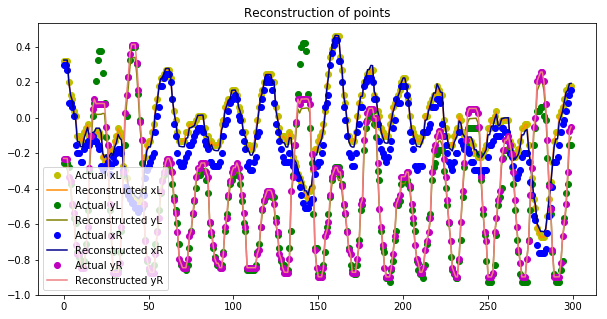

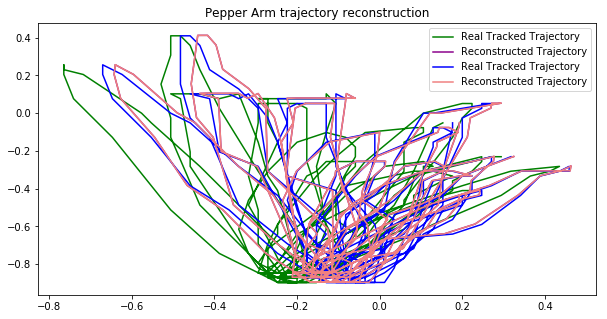

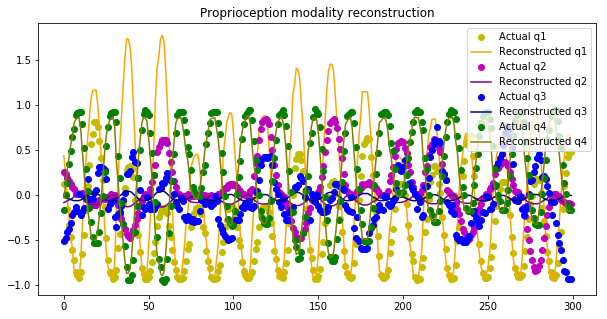

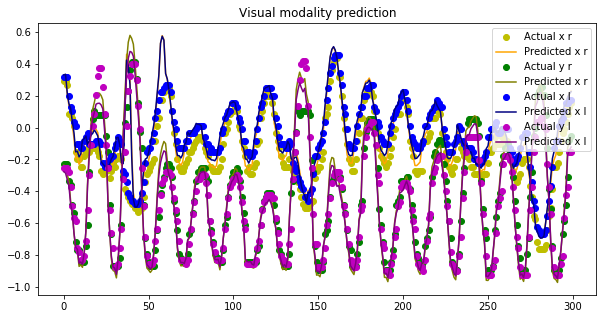

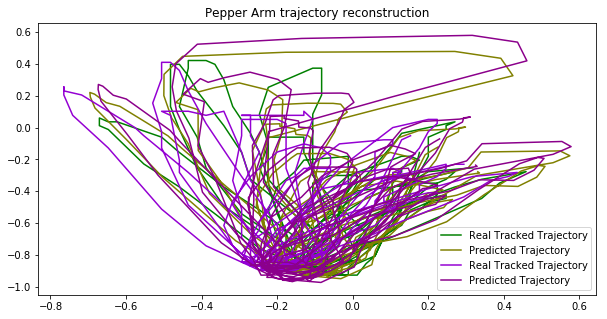

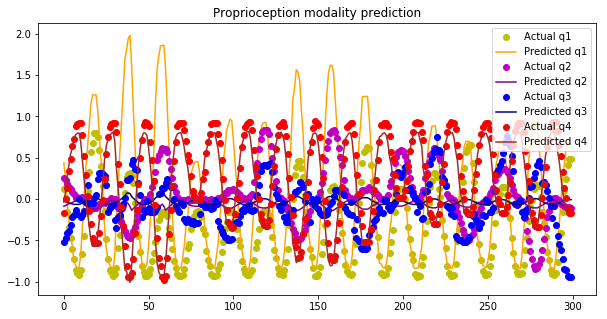

In [40]:
#reconstructed

plt.plot(real_xL, 'yo', label="Actual xL")
plt.plot(recon_xL, label="Reconstructed xL", color = "darkorange")
plt.plot(real_yL, 'go',label="Actual yL")
plt.plot(recon_yL, label="Reconstructed yL", color = "olive")
plt.plot(real_xR, 'bo', label="Actual xR")
plt.plot(recon_xR, label="Reconstructed xR", color="darkblue")
plt.plot(real_yR, 'mo',label="Actual yR")
plt.plot(recon_yR, label="Reconstructed yR", color="lightcoral")
plt.title('Reconstruction of points')
plt.legend()
plt.show()

plt.plot(real_xR, real_yR, label='Real Tracked Trajectory', color='green')
plt.plot(recon_xR, recon_yR, label='Reconstructed Trajectory', color='darkmagenta')
plt.plot(real_xL, real_yR, label='Real Tracked Trajectory', color='blue')
plt.plot(recon_xR, recon_yR, label='Reconstructed Trajectory', color='lightcoral')
plt.title("Pepper Arm trajectory reconstruction")
plt.legend()
plt.show() 

plt.plot(real_q1, 'yo', label="Actual q1")
plt.plot(recon_q1, label="Reconstructed q1", color='orange')
plt.plot(real_q2, 'mo', label="Actual q2")
plt.plot(recon_q2, label="Reconstructed q2", color='purple')
plt.plot(real_q3, 'bo', label="Actual q3")
plt.plot(recon_q3, label="Reconstructed q3", color='navy')
plt.plot(real_q4, 'go', label="Actual q4")
plt.plot(recon_q4, label="Reconstructed q4", color='olive')
plt.title('Proprioception modality reconstruction')
plt.legend()
plt.show()

#predicted

plt.plot(real_xR, 'yo', label="Actual x r")
plt.plot(pred_xR, label="Predicted x r", color='orange')
plt.plot(real_yR, 'go',label="Actual y r")
plt.plot(pred_yR, label="Predicted x r", color='olive')
plt.plot(real_xL, 'bo', label="Actual x l")
plt.plot(pred_xL, label="Predicted x l", color='navy')
plt.plot(real_yL, 'mo',label="Actual y l")
plt.plot(pred_yL, label="Predicted x l", color='purple')
plt.title('Visual modality prediction')
plt.legend()
plt.show()

plt.plot(real_xL, real_yL, label='Real Tracked Trajectory', color='green')
plt.plot(pred_xL, pred_yL, label='Predicted Trajectory', color='olive')
plt.plot(real_xR, real_yR, label='Real Tracked Trajectory', color='darkviolet')
plt.plot(pred_xR, pred_yR, label='Predicted Trajectory', color='darkmagenta')
plt.title("Pepper Arm trajectory reconstruction")
plt.legend()
plt.show()

plt.plot(real_q1, 'yo', label="Actual q1")
plt.plot(pred_q1, label="Predicted q1", color='orange')
plt.plot(real_q2, 'mo', label="Actual q2")
plt.plot(pred_q2, label="Predicted q2", color='purple')
plt.plot(real_q3, 'bo', label="Actual q3")
plt.plot(pred_q3, label="Predicted q3", color='navy')
plt.plot(real_q4, 'ro', label="Actual q4")
plt.plot(pred_q4, label="Predicted q4", color='brown')
plt.title('Proprioception modality prediction')
plt.legend()
plt.show()